In [1]:
import pandas as pd

In [3]:
dr6_splus = pd.read_csv("dr6_list.csv")

In [2]:
pd.read_parquet("/home/astrodados3/dados/specz_erik/specz_compilation_20250327.parquet")

,ID,RA,DEC,z,z_significant_figures,e_z,f_z,original_f_z,class_spec,subclass,subsubclass,original_class_spec,source
0,8806812,2.480254,-84.905495,0.060769,6,1.500000e-04,1,SLS,GALAXY,None,None,G,EXTERNAL_NED_20096dF...C...0000J
1,8826981,8.680293,-85.709440,0.047990,5,1.500000e-04,1,SLS,GALAXY,None,None,G,EXTERNAL_NED_20096dF...C...0000J
2,9141642,3.709595,-86.993100,0.016842,6,1.730000e-04,1,SLS,GALAXY,None,None,G,EXTERNAL_NED_2012ApJS..199...26H
3,11260614,1.654010,-86.047330,-0.000017,17,1.000692e-07,1,1,STAR,None,FULL,None,VizieR_J/A+A/542/A48/ambredr1
4,11624011,3.331452,-84.994020,0.000013,17,1.334256e-06,1,A,STAR?,None,None,None,VizieR_V/137D/XHIP
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16238855,36733864,357.710000,6.169333,0.056000,3,NaN,-1,nan,UNCLEAR,None,None,None,VizieR_J/A+A/659/A126/tablea1
16238856,36735373,359.779170,8.585000,0.966000,3,NaN,-1,nan,UNCLEAR,None,None,None,VizieR_J/ApJ/893/77/table1
16238857,36735429,356.050000,7.870000,0.069000,3,NaN,-1,nan,UNCLEAR,None,None,None,VizieR_J/ApJ/807/169/sncat
16238858,36747686,355.970000,5.555000,0.056000,3,NaN,-1,nan,UNCLEAR,None,None,None,VizieR_J/ApJ/835/74/table1


In [9]:
#!/usr/bin/env python
import os
import re
import glob
from collections import defaultdict

import numpy as np
import pandas as pd
import healpy as hp
import pyarrow.parquet as pq

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
import astropy.units as u

# -------------------------------------------------
# CONFIG – adjust paths/parameters to your setup
# -------------------------------------------------

SPLUS_BANDS = ["R", "I", "G", "U", "Z", "F378", "F395", "F410",
               "F430", "F515", "F660", "F861"]

# Base dirs where images live; we’ll search in each
SPLUS_IMAGES_PATH = ["/home/astrodados3/splus/idr6/"]

# Cutout configuration
SPLUS_CUTOUT_SIZE = 96  # pixels
# If True, only make S-PLUS cutouts for objects that have a Gaia match
ONLY_GAIA_MATCH_CUTOUTS = True

# Your driver list (one field per line)
DR6_LIST = "dr6_list.csv"   # columns: field, ra, dec  (ra/dec lowercase)

# Pattern for S-PLUS dual catalogs (if ever needed)
SPLUS_CAT_PATTERN = "/home/astrodados3/splus/idr6_final/main/SPLUS-*_dual.fits"

# Gaia DR3 source chunks (GaiaSource_<start>-<end>.csv.gz, HEALPix level-8 ranges)
GAIA_DIR = "/home/astrodados/gaia_dr3"

# Gaia XP spectra chunks (XpContinuousMeanSpectrum_<start>-<end>.csv.gz, same scheme)
GAIA_SPEC_DIR = "/home/astrodados4/downloads/gaia_spectra"

# ZTF HiPS parquet root
ZTF_ROOT = "/home/astrodados3/dados/ztf22/dataset"
# We’ll search over these HiPS orders (you have Norder=2,3,4)
ZTF_NORDERS = [2, 3, 4, 5, 6, 7]

# DESI spectra
DESI_ROOT = "/home/astrodados4/downloads/desi_spectra"
DESI_TILES_CSV = "desi_tiles.csv"   # must contain TILEID, TILERA, TILEDEC
DESI_TILE_RADIUS_DEG = 1.7         # match S-PLUS field center to DESI tile center

# APOGEE allStar DR17
APOGEE_PATH = "/home/astrodados4/downloads/allStar-dr17-synspec_rev1.fits"

# spec-z compilation
SPECZ_PATH = "/home/astrodados3/dados/specz_erik/specz_compilation_20250327.parquet"

# VISTA catalog root
VISTA_DIR = "/home/astrodados4/downloads/vista"



# HEALPix schemes for Gaia / Gaia XP
GAIA_NSIDE = 256
GAIA_NEST = True

GAIA_SPEC_NSIDE = GAIA_NSIDE
GAIA_SPEC_NEST = GAIA_NEST

# Matching radii
MATCH_RADIUS_SPLUS_VISTA = 1.0 * u.arcsec
MATCH_RADIUS_SPLUS_GAIA    = 1.2 * u.arcsec
MATCH_RADIUS_SPLUS_ZTF     = 1.0 * u.arcsec
MATCH_RADIUS_SPLUS_DESI    = 1.0 * u.arcsec
MATCH_RADIUS_SPLUS_APOGEE  = 1.0 * u.arcsec
MATCH_RADIUS_SPLUS_SPECZ   = 1.0 * u.arcsec

# How many S-PLUS rows to process at once (per field)
CHUNK_SIZE = 300000

# -------------------------------------------------
# Small helpers
# -------------------------------------------------

def radec_to_hpix(ra_deg, dec_deg, nside, nest=True):
    ra = np.asarray(ra_deg)
    dec = np.asarray(dec_deg)
    theta = np.radians(90.0 - dec)
    phi = np.radians(ra)
    return hp.ang2pix(nside, theta, phi, nest=nest)

def build_range_index(directory, prefix, suffix):
    """
    Build list of (start, end, path) for files like:
      prefix<start>-<end>suffix

    For Gaia DR3 bulk download, <start>,<end> are HEALPix level-8 indices.
    """
    entries = []
    pattern = re.escape(prefix) + r"(\d+)-(\d+)" + re.escape(suffix)
    for path in glob.glob(os.path.join(directory, prefix + "*" + suffix)):
        fname = os.path.basename(path)
        m = re.search(pattern, fname)
        if not m:
            continue
        start = int(m.group(1))
        end   = int(m.group(2))
        entries.append((start, end, path))
    entries.sort(key=lambda x: x[0])
    return entries

def files_for_hpix_ranges(hpix_indices, range_index):
    """
    Given a list of HEALPix indices and a list of (start,end,path) ranges,
    return the subset of files whose [start,end] overlaps those indices.
    """
    hpix_set = set(int(h) for h in np.unique(hpix_indices))
    files = set()
    for start, end, path in range_index:
        for h in list(hpix_set):
            if start <= h <= end:
                files.add(path)
    return sorted(files)

def ztf_file_for_hpix(hpix, norder, root=ZTF_ROOT):
    """
    hipscat/LSDB-like layout:

      Norder=<norder>/
        Dir=<block_start>/
          Npix=<hpix>.parquet

    where block_start is the start of a 10000-pixel block that contains hpix.
    E.g. hpix=51852 -> Dir=50000
    """
    hpix = int(hpix)
    block_size = 10000
    block_start = (hpix // block_size) * block_size
    directory = f"Dir={block_start}"

    return os.path.join(
        root,
        f"Norder={norder}",
        directory,
        f"Npix={hpix}.parquet",
    )

def desi_file_paths_for_tiles(tile_ids):
    """
    For a list of DESI TILEID values, return all coadd-*.fits files under
    DESI_ROOT/<TILEID>/<NIGHT>/coadd-*-TILEID-thru*.fits (or fallback coadd-*.fits).
    """
    paths = []
    for tileid in tile_ids:
        tileid = int(tileid)
        tile_dir = os.path.join(DESI_ROOT, str(tileid))
        if not os.path.isdir(tile_dir):
            print(f"      [DESI] Tile dir not found for TILEID={tileid}: {tile_dir}")
            continue

        pattern_main = os.path.join(tile_dir, "*", f"coadd-*-{tileid}-thru*.fits")
        tile_paths = glob.glob(pattern_main)
        if not tile_paths:
            # fallback: any coadd file
            pattern_fallback = os.path.join(tile_dir, "*", "coadd-*.fits")
            tile_paths = glob.glob(pattern_fallback)

        tile_paths = sorted(tile_paths)
        if not tile_paths:
            print(f"      [DESI] No coadd files in {tile_dir}")
        else:
            print(f"      [DESI] TILEID {tileid} → {len(tile_paths)} coadd files")
            paths.extend(tile_paths)

    return paths

def match_catalogs(src_coord, cat_coord, max_sep):
    idx, d2d, _ = src_coord.match_to_catalog_sky(cat_coord)
    idx[d2d > max_sep] = -1
    return idx

def read_gaia_ecsv(path):
    """
    Read Gaia DR3 bulk-download file (GaiaSource_* or XpContinuousMeanSpectrum_*)
    using the required ECSV reader configuration.
    """
    print(f"        [Gaia/ECSV] Opening {path}")
    tab = Table.read(
        path,
        format="ascii.ecsv",
        guess=False,
        fill_values=[('null', 99), ('nan', 99)],
    )
    return tab.to_pandas()

# -------------------------------------------------
# S-PLUS per-field (catalog)
# -------------------------------------------------

def get_splus_path_for_field(field_name):
    """
    Return the S-PLUS dual catalog FITS path for a given field.

    Here we assume files like:
      /home/astrodados3/splus/idr6_final/main/HYDRA-0011_dual.fits
    i.e., <FIELD>_dual.fits
    """
    pattern = os.path.join(
        "/home/astrodados3/splus/idr6_final/main",
        f"{field_name}*.fits"
    )
    print(f"  [SPLUS] Globbing S-PLUS files with pattern: {pattern}")
    candidates = glob.glob(pattern)
    print(f"  [SPLUS] Found {len(candidates)} S-PLUS files for field {field_name}.")
    if len(candidates) == 1:
        return candidates[0]

    raise RuntimeError(
        f"Please define S-PLUS file path for field '{field_name}' "
        f"in get_splus_path_for_field()."
    )

def load_splus_for_field(field_row):
    """
    Open ONLY the S-PLUS catalog corresponding to this field.
    Assumes entire tile is in one FITS file.
    """
    field_name = field_row["field"]
    fits_path = get_splus_path_for_field(field_name)
    print(f"  [SPLUS] Opening S-PLUS file: {fits_path}")
    tab = Table.read(fits_path)
    df = tab.to_pandas()
    if "ra" not in df.columns or "dec" not in df.columns:
        raise ValueError(f"{fits_path} has no 'ra'/'dec' columns.")
    print(f"  [SPLUS] Loaded {len(df)} rows for field {field_name}")
    return df

# -------------------------------------------------
# S-PLUS image cutouts (stored in parquet)
# -------------------------------------------------

def get_splus_image_path_for_band(field_name, band):
    """
    Find the S-PLUS image file for a given field and band,
    trying all base paths in SPLUS_IMAGES_PATH.
    Expected pattern:
      <base>/<FIELD>/<FIELD>_<BAND>.fits.fz
    Example:
      /home/astrodados3/splus/idr6/HYDRA-0011/HYDRA-0011_F378.fits.fz
    """
    for base in SPLUS_IMAGES_PATH:
        path = os.path.join(base, field_name, f"{field_name}_{band}.fits.fz")
        if os.path.exists(path):
            return path
    raise FileNotFoundError(
        f"No image found for field {field_name}, band {band} "
        f"in any of {SPLUS_IMAGES_PATH}"
    )

def process_chunk_splus_images(field_name,
                               splus_chunk,
                               cutout_size=SPLUS_CUTOUT_SIZE,
                               mask_rows=None):
    """
    For this S-PLUS chunk, generate cutouts in all SPLUS_BANDS and
    return a DataFrame with columns of pixel data:

        splus_cut_R, splus_cut_I, ..., splus_cut_F378, ...

    Each cell is either:
        - a 1D float32 array of length cutout_size*cutout_size,
        - or None if cutout could not be made or was skipped.

    If mask_rows is provided (Series aligned with splus_chunk.index),
    cutouts are generated ONLY for rows where mask_rows is True.
    """
    if splus_chunk.empty:
        return pd.DataFrame(index=splus_chunk.index)

    print(f"      [SPLUS IMG] Making cutouts for chunk with {len(splus_chunk)} rows")

    mask_arr = None
    if mask_rows is not None:
        mask_rows = mask_rows.reindex(splus_chunk.index)
        mask_arr = mask_rows.fillna(False).values

    coords = SkyCoord(
        splus_chunk["ra"].values * u.deg,
        splus_chunk["dec"].values * u.deg,
    )

    result = {f"splus_cut_{b}": [None] * len(splus_chunk) for b in SPLUS_BANDS}

    for band in SPLUS_BANDS:
        col_name = f"splus_cut_{band}"
        try:
            img_path = get_splus_image_path_for_band(field_name, band)
        except FileNotFoundError as e:
            print(f"      [SPLUS IMG] {e}")
            continue

        print(f"      [SPLUS IMG] Using image {img_path} for band {band}")
        try:
            with fits.open(img_path, memmap=True) as hdul:
                if len(hdul) <= 1 or hdul[1].data is None:
                    print(f"      [SPLUS IMG] HDU 1 has no data in {img_path}, skipping band {band}")
                    continue
                image_hdu = hdul[1]
                data = image_hdu.data
                hdr = image_hdu.header
                wcs = WCS(hdr)
        except Exception as e:
            print(f"      [SPLUS IMG] Failed to open {img_path}: {e}")
            continue

        for pos, coord in enumerate(coords):
            if mask_arr is not None and not mask_arr[pos]:
                continue

            try:
                cut = Cutout2D(data, position=coord, wcs=wcs, size=cutout_size)
            except Exception:
                continue

            result[col_name][pos] = cut.data.astype("float32").ravel()

    cutout_df = pd.DataFrame(result, index=splus_chunk.index)
    return cutout_df

# -------------------------------------------------
# Per-chunk external survey processing
#   Gaia / XP / ZTF / DESI / APOGEE / spec-z
# -------------------------------------------------

def process_chunk_gaia(splus_chunk, gaia_index):
    if splus_chunk.empty:
        return pd.DataFrame(index=splus_chunk.index)

    print(f"      [Gaia] Processing chunk with {len(splus_chunk)} S-PLUS rows")

    splus_coord = SkyCoord(
        splus_chunk["ra"].values * u.deg,
        splus_chunk["dec"].values * u.deg,
    )
    hpix_gaia = radec_to_hpix(
        splus_chunk["ra"], splus_chunk["dec"], GAIA_NSIDE, GAIA_NEST
    )

    needed_files = files_for_hpix_ranges(hpix_gaia, gaia_index)
    print(f"      [Gaia] Files needed for this chunk: {len(needed_files)}")
    if not needed_files:
        return pd.DataFrame(index=splus_chunk.index)

    gaia_rows = []
    for path in needed_files:
        df = read_gaia_ecsv(path)
        gaia_rows.append(df)

    gaia_cat = pd.concat(gaia_rows, ignore_index=True)
    print(f"      [Gaia] Total Gaia rows loaded for this chunk: {len(gaia_cat)}")

    if "ra" not in gaia_cat.columns or "dec" not in gaia_cat.columns:
        raise ValueError("Gaia catalog has no 'ra'/'dec' columns.")

    gaia_coord = SkyCoord(
        gaia_cat["ra"].values * u.deg,
        gaia_cat["dec"].values * u.deg,
    )
    match_idx = match_catalogs(splus_coord, gaia_coord, MATCH_RADIUS_SPLUS_GAIA)
    n_matches = np.sum(match_idx != -1)
    print(f"      [Gaia] Matched {n_matches} / {len(splus_chunk)}")

    out = []
    for idx in match_idx:
        out.append({} if idx == -1 else gaia_cat.iloc[int(idx)].to_dict())

    gaia_df = pd.DataFrame(out, index=splus_chunk.index)
    if not gaia_df.empty:
        gaia_df.columns = [f"gaia_{c}" for c in gaia_df.columns]

    return gaia_df

def process_chunk_gaia_spectra(gaia_df, gaia_spec_index):
    """
    Match Gaia XP spectra to the Gaia matches and keep XP 'source_id' so
    it appears as 'gaiaxp_source_id' in the final datacube for QA.
    """
    if gaia_df.empty or "gaia_source_id" not in gaia_df.columns:
        print("      [GaiaXP] No Gaia matches or missing 'gaia_source_id'.")
        return pd.DataFrame(index=gaia_df.index)

    sid_series = gaia_df["gaia_source_id"].dropna()
    if sid_series.empty:
        print("      [GaiaXP] No valid source_ids.")
        return pd.DataFrame(index=gaia_df.index)

    if not {"gaia_ra", "gaia_dec"}.issubset(gaia_df.columns):
        print("      [GaiaXP] Missing 'gaia_ra'/'gaia_dec'.")
        return pd.DataFrame(index=gaia_df.index)

    ra = gaia_df["gaia_ra"].astype(float)
    dec = gaia_df["gaia_dec"].astype(float)
    mask_valid = (~ra.isna()) & (~dec.isna()) & (~gaia_df["gaia_source_id"].isna())
    if not mask_valid.any():
        print("      [GaiaXP] No rows with valid RA/DEC + source_id.")
        return pd.DataFrame(index=gaia_df.index)

    hpix_spec = radec_to_hpix(
        ra[mask_valid].values,
        dec[mask_valid].values,
        GAIA_SPEC_NSIDE,
        GAIA_SPEC_NEST,
    )
    needed_files = files_for_hpix_ranges(hpix_spec, gaia_spec_index)
    print(f"      [GaiaXP] Files needed: {len(needed_files)}")

    if not needed_files:
        return pd.DataFrame(index=gaia_df.index)

    needed_source_ids = set(sid_series.astype("int64").values.tolist())

    spec_rows = []
    for path in needed_files:
        df = read_gaia_ecsv(path)
        if "source_id" not in df.columns:
            print(f"        [GaiaXP] 'source_id' missing in {path}, skipping.")
            continue
        df = df[df["source_id"].isin(needed_source_ids)]
        print(f"        [GaiaXP] {len(df)} rows match in {path}")
        if not df.empty:
            # ensure int64
            df["source_id"] = df["source_id"].astype("int64")
            spec_rows.append(df)

    if not spec_rows:
        print("      [GaiaXP] No XP spectra matched.")
        return pd.DataFrame(index=gaia_df.index)

    spec_cat = pd.concat(spec_rows, ignore_index=True)
    spec_unique = spec_cat.drop_duplicates(subset="source_id", keep="first").copy()
    spec_unique = spec_unique.set_index("source_id")
    spec_unique["source_id"] = spec_unique.index.values

    out = []
    for sid in gaia_df["gaia_source_id"]:
        if pd.isna(sid):
            out.append({})
        else:
            sid_int = int(sid)
            if sid_int in spec_unique.index:
                out.append(spec_unique.loc[sid_int].to_dict())
            else:
                out.append({})

    gaiaxp_df = pd.DataFrame(out, index=gaia_df.index)
    if not gaiaxp_df.empty:
        gaiaxp_df.columns = [f"gaiaxp_{c}" for c in gaiaxp_df.columns]

        if "gaiaxp_source_id" in gaiaxp_df.columns:
            mask_both = (~gaiaxp_df["gaiaxp_source_id"].isna()) & (~gaia_df["gaia_source_id"].isna())
            n_both = mask_both.sum()
            if n_both > 0:
                n_mismatch = (gaiaxp_df["gaiaxp_source_id"][mask_both].astype("int64")
                              != gaia_df["gaia_source_id"][mask_both].astype("int64")).sum()
                print(f"      [GaiaXP] QA: {n_both} rows with both IDs, "
                      f"{n_mismatch} mismatches between gaiaxp_source_id and gaia_source_id")

    return gaiaxp_df

def process_chunk_ztf(splus_chunk):
    """
    Cross-match this S-PLUS chunk with ZTF HiPS parquet.
    We search across multiple HiPS orders (ZTF_NORDERS).
    """
    if splus_chunk.empty:
        return pd.DataFrame(index=splus_chunk.index)

    print(f"      [ZTF] Processing chunk with {len(splus_chunk)} S-PLUS rows")
    print(f"      [ZTF] Orders considered: {ZTF_NORDERS}")

    ra = splus_chunk["ra"].values
    dec = splus_chunk["dec"].values

    # Collect all parquet files that correspond to the hpix of this chunk,
    # across all requested orders.
    paths_set = set()

    for norder in ZTF_NORDERS:
        nside = 2 ** norder
        hpix_ztf = radec_to_hpix(ra, dec, nside, nest=True)
        unique_hpix = np.unique(hpix_ztf)
        print(f"      [ZTF] Norder={norder}, NSIDE={nside}, unique hpix={len(unique_hpix)}")

        for hpix_val in unique_hpix:
            path = ztf_file_for_hpix(hpix_val, norder=norder)
            if os.path.exists(path):
                paths_set.add(path)

    print(f"      [ZTF] Total parquet files found across orders: {len(paths_set)}")

    if not paths_set:
        return pd.DataFrame(index=splus_chunk.index)

    ztf_rows = []
    for path in sorted(paths_set):
        print(f"        [ZTF] Reading {path}")
        tab = pq.read_table(path).to_pandas()
        ztf_rows.append(tab)

    if not ztf_rows:
        return pd.DataFrame(index=splus_chunk.index)

    ztf_cat = pd.concat(ztf_rows, ignore_index=True)
    print(f"      [ZTF] Total ZTF rows loaded: {len(ztf_cat)}")
    print(f"      [ZTF] Columns: {list(ztf_cat.columns)}")

    # Robust RA/DEC column detection
    ra_col = None
    dec_col = None
    for cand in ("ra", "RA", "Ra"):
        if cand in ztf_cat.columns:
            ra_col = cand
            break
    for cand in ("dec", "DEC", "Dec"):
        if cand in ztf_cat.columns:
            dec_col = cand
            break

    if ra_col is None or dec_col is None:
        raise ValueError("ZTF parquet must contain RA/DEC-like columns (ra/dec or RA/DEC).")

    ztf_coord = SkyCoord(
        ztf_cat[ra_col].values * u.deg,
        ztf_cat[dec_col].values * u.deg,
    )
    splus_coord = SkyCoord(
        ra * u.deg,
        dec * u.deg,
    )

    match_idx = match_catalogs(splus_coord, ztf_coord, MATCH_RADIUS_SPLUS_ZTF)
    n_matches = np.sum(match_idx != -1)
    print(f"      [ZTF] Matched {n_matches} / {len(splus_chunk)}")

    out = []
    for idx in match_idx:
        if idx == -1:
            out.append({})
        else:
            out.append(ztf_cat.iloc[int(idx)].to_dict())

    ztf_df = pd.DataFrame(out, index=splus_chunk.index)
    if not ztf_df.empty:
        ztf_df.columns = [f"ztf_{c}" for c in ztf_df.columns]

    return ztf_df

def process_chunk_desi(splus_chunk, desi_tile_ids):
    if splus_chunk.empty:
        return pd.DataFrame(index=splus_chunk.index)

    print(f"      [DESI] Processing chunk with {len(splus_chunk)} S-PLUS rows")
    print(f"      [DESI] Tiles considered for this field: {len(desi_tile_ids)}")

    if not desi_tile_ids:
        return pd.DataFrame(index=splus_chunk.index)

    splus_coord = SkyCoord(
        splus_chunk["ra"].values * u.deg,
        splus_chunk["dec"].values * u.deg,
    )

    desi_rows = [ {} for _ in range(len(splus_chunk)) ]

    paths = desi_file_paths_for_tiles(desi_tile_ids)
    print(f"      [DESI] Total DESI coadd files to inspect: {len(paths)}")

    for path in paths:
        print(f"        [DESI] Opening {path}")
        with fits.open(path) as hd:
            if "FIBERMAP" not in hd:
                print("        [DESI] No FIBERMAP extension, skipping.")
                continue
            fibermap = Table(hd["FIBERMAP"].data).to_pandas()

        if "TARGET_RA" not in fibermap.columns or "TARGET_DEC" not in fibermap.columns:
            print("        [DESI] FIBERMAP missing TARGET_RA/DEC, skipping.")
            continue

        fibermap = fibermap.dropna(subset=["TARGET_RA", "TARGET_DEC"])
        if fibermap.empty:
            print("        [DESI] All TARGET_RA/DEC are NaN in this file, skipping.")
            continue

        desi_coord = SkyCoord(
            fibermap["TARGET_RA"].values * u.deg,
            fibermap["TARGET_DEC"].values * u.deg,
        )
        match_idx = match_catalogs(splus_coord, desi_coord, MATCH_RADIUS_SPLUS_DESI)
        n_matches = np.sum(match_idx != -1)
        print(f"        [DESI] Matched {n_matches} / {len(splus_chunk)} in this file")

        for i, idx in enumerate(match_idx):
            if idx == -1:
                continue
            if not desi_rows[i]:
                row = dict(fibermap.iloc[int(idx)])
                row["desi_file"] = path
                desi_rows[i] = row

    desi_df = pd.DataFrame(desi_rows, index=splus_chunk.index)
    if not desi_df.empty:
        desi_df.columns = [f"desi_{c}" for c in desi_df.columns]

    return desi_df

def process_chunk_apogee(splus_chunk, apogee_cat, apogee_coord):
    """
    Cross-match this S-PLUS chunk with APOGEE allStar DR17 (single big table).
    """
    if splus_chunk.empty or apogee_cat is None or apogee_coord is None:
        return pd.DataFrame(index=splus_chunk.index)

    print(f"      [APOGEE] Processing chunk with {len(splus_chunk)} S-PLUS rows")

    splus_coord = SkyCoord(
        splus_chunk["ra"].values * u.deg,
        splus_chunk["dec"].values * u.deg,
    )

    match_idx = match_catalogs(splus_coord, apogee_coord, MATCH_RADIUS_SPLUS_APOGEE)
    n_matches = np.sum(match_idx != -1)
    print(f"      [APOGEE] Matched {n_matches} / {len(splus_chunk)}")

    out = []
    for idx in match_idx:
        out.append({} if idx == -1 else apogee_cat.iloc[int(idx)].to_dict())

    apogee_df = pd.DataFrame(out, index=splus_chunk.index)
    if not apogee_df.empty:
        apogee_df.columns = [f"apogee_{c}" for c in apogee_df.columns]

    return apogee_df

def process_chunk_specz(splus_chunk, specz_cat, specz_coord):
    """
    Cross-match this S-PLUS chunk with spec-z compilation (single parquet table).
    """
    if splus_chunk.empty or specz_cat is None or specz_coord is None:
        return pd.DataFrame(index=splus_chunk.index)

    print(f"      [SPECZ] Processing chunk with {len(splus_chunk)} S-PLUS rows")

    splus_coord = SkyCoord(
        splus_chunk["ra"].values * u.deg,
        splus_chunk["dec"].values * u.deg,
    )

    match_idx = match_catalogs(splus_coord, specz_coord, MATCH_RADIUS_SPLUS_SPECZ)
    n_matches = np.sum(match_idx != -1)
    print(f"      [SPECZ] Matched {n_matches} / {len(splus_chunk)}")

    out = []
    for idx in match_idx:
        out.append({} if idx == -1 else specz_cat.iloc[int(idx)].to_dict())

    specz_df = pd.DataFrame(out, index=splus_chunk.index)
    if not specz_df.empty:
        specz_df.columns = [f"specz_{c}" for c in specz_df.columns]

    return specz_df

def load_vista_for_field(field_name):
    """
    Load the VISTA catalog parquet for a given S-PLUS field.

    Expected filename pattern:
      VISTA_DIR/<field_name>*.parquet

    Example:
      /home/astrodados4/downloads/vista/SPLUS-n11s28.parquet
    """
    pattern = os.path.join(VISTA_DIR, f"{field_name}*.parquet")
    print(f"  [VISTA] Globbing VISTA files with pattern: {pattern}")
    candidates = glob.glob(pattern)
    print(f"  [VISTA] Found {len(candidates)} VISTA files for field {field_name}.")

    if not candidates:
        print(f"  [VISTA] No VISTA catalog for field {field_name}")
        return None

    # If there are multiple, just pick the first and warn
    if len(candidates) > 1:
        print(f"  [VISTA] Multiple VISTA files for {field_name}, using first: {candidates[0]}")

    vista_path = candidates[0]
    print(f"  [VISTA] Opening {vista_path}")
    vista_cat = pd.read_parquet(vista_path)

    if "ra" not in vista_cat.columns or "dec" not in vista_cat.columns:
        raise ValueError(f"VISTA catalog {vista_path} has no 'ra'/'dec' columns.")

    # Make sure RA/DEC are floats
    vista_cat["ra"] = vista_cat["ra"].astype(float)
    vista_cat["dec"] = vista_cat["dec"].astype(float)

    print(f"  [VISTA] Loaded {len(vista_cat)} VISTA rows for field {field_name}")
    return vista_cat

def process_chunk_vista(splus_chunk, vista_cat, vista_coord):
    """
    Cross-match this S-PLUS chunk with the per-field VISTA catalog.

    vista_cat: pandas DataFrame with columns 'ra', 'dec' + others
    vista_coord: SkyCoord built from vista_cat['ra'], vista_cat['dec']
    """
    if splus_chunk.empty or vista_cat is None or vista_coord is None:
        return pd.DataFrame(index=splus_chunk.index)

    print(f"      [VISTA] Processing chunk with {len(splus_chunk)} S-PLUS rows")

    splus_coord = SkyCoord(
        splus_chunk["ra"].values * u.deg,
        splus_chunk["dec"].values * u.deg,
    )

    match_idx = match_catalogs(splus_coord, vista_coord, MATCH_RADIUS_SPLUS_VISTA)
    n_matches = np.sum(match_idx != -1)
    print(f"      [VISTA] Matched {n_matches} / {len(splus_chunk)}")

    out = []
    for idx in match_idx:
        out.append({} if idx == -1 else vista_cat.iloc[int(idx)].to_dict())

    vista_df = pd.DataFrame(out, index=splus_chunk.index)
    if not vista_df.empty:
        vista_df.columns = [f"vista_{c}" for c in vista_df.columns]

    return vista_df

# -------------------------------------------------
# Per-field datacube
# -------------------------------------------------

def build_datacube_for_field(field_row,
                             gaia_index,
                             gaia_spec_index,
                             desi_tiles,
                             desi_tiles_coord,
                             apogee_cat,
                             apogee_coord,
                             specz_cat,
                             specz_coord):
    field_name = field_row["field"]
    field_ra = float(field_row["ra"])
    field_dec = float(field_row["dec"])

    print(f"\n=== Field {field_name} ({field_ra}, {field_dec}) ===")

    # 0. Determine DESI tiles near this field (based on field center)
    field_center = SkyCoord(field_ra * u.deg, field_dec * u.deg)
    sep = field_center.separation(desi_tiles_coord)
    mask_tiles = sep.deg < DESI_TILE_RADIUS_DEG
    field_tile_ids = desi_tiles.loc[mask_tiles, "TILEID"].astype(int).tolist()
    print(f"  [DESI] Tiles within {DESI_TILE_RADIUS_DEG} deg of field center: {len(field_tile_ids)}")

    # 1. Open ONLY the S-PLUS catalog for this field
    splus_field = load_splus_for_field(field_row)
    print(f"  [SPLUS] Objects in this field file: {len(splus_field)}")

    # 1b. Load VISTA catalog for this field (if available)
    vista_cat = load_vista_for_field(field_name)
    vista_coord = None
    if vista_cat is not None:
        vista_coord = SkyCoord(
            vista_cat["ra"].values * u.deg,
            vista_cat["dec"].values * u.deg,
        )

    all_chunks = []

    # 2. Process this field in chunks (for memory)
    for start in range(0, len(splus_field), CHUNK_SIZE):
        end = min(start + CHUNK_SIZE, len(splus_field))
        print(f"    [Field {field_name}] chunk {start}-{end}")
        chunk = splus_field.iloc[start:end].copy()

        # Gaia first (so we can decide which rows get cutouts)
        gaia_df = process_chunk_gaia(chunk, gaia_index)
        if "gaia_source_id" in gaia_df.columns:
            gaia_df["gaia_source_id"] = gaia_df["gaia_source_id"].astype("Int64")

        # Mask for cutouts: only rows with Gaia matches (if enabled)
        cutout_mask = None
        if ONLY_GAIA_MATCH_CUTOUTS and not gaia_df.empty and "gaia_source_id" in gaia_df.columns:
            cutout_mask = ~gaia_df["gaia_source_id"].isna()
            print(f"    [SPLUS IMG] Gaia-matched rows for cutouts: {cutout_mask.sum()} / {len(cutout_mask)}")

        # S-PLUS cutouts stored directly in parquet
        splus_img_df = process_chunk_splus_images(field_name, chunk, mask_rows=cutout_mask)

        # Gaia XP, ZTF, DESI, APOGEE, spec-z
        gaiaxp_df = process_chunk_gaia_spectra(gaia_df, gaia_spec_index)
        ztf_df    = process_chunk_ztf(chunk)
        desi_df   = process_chunk_desi(chunk, field_tile_ids)
        apogee_df = process_chunk_apogee(chunk, apogee_cat, apogee_coord)
        specz_df  = process_chunk_specz(chunk, specz_cat, specz_coord)
        vista_df  = process_chunk_vista(chunk, vista_cat, vista_coord)

        # QA: XP IDs
        if not gaiaxp_df.empty and "gaiaxp_source_id" in gaiaxp_df.columns and "gaia_source_id" in gaia_df.columns:
            mask = (~gaiaxp_df["gaiaxp_source_id"].isna()) & (~gaia_df["gaia_source_id"].isna())
            if mask.any():
                same_id = (gaiaxp_df.loc[mask, "gaiaxp_source_id"].astype("int64") ==
                           gaia_df.loc[mask, "gaia_source_id"].astype("int64"))
                print("    [GaiaXP] Fraction of rows with matching IDs:", float(same_id.mean()))

        merged = (chunk
                  .join(splus_img_df)
                  .join(gaia_df)
                  .join(gaiaxp_df)
                  .join(ztf_df)
                  .join(desi_df)
                  .join(apogee_df)
                  .join(specz_df)
                  .join(vista_df))
        all_chunks.append(merged)

    datacube_field = pd.concat(all_chunks, ignore_index=True)
    out_name = f"datacube_{field_name}.parquet"
    datacube_field.to_parquet(out_name)
    print(f"  [OUT] Saved {len(datacube_field)} rows to {out_name}")

    del datacube_field
    del all_chunks
    del splus_field

# -------------------------------------------------
# Main
# -------------------------------------------------

def main():
    # Driver list
    dr6_splus = pd.read_csv(DR6_LIST)
    dr6_splus = dr6_splus[dr6_splus['field'] == 'STRIPE82-0001']
    print(f"Loaded {len(dr6_splus)} rows from {DR6_LIST}")

    # Gaia indices
    gaia_index = build_range_index(GAIA_DIR, "GaiaSource_", ".csv.gz")
    print(f"Indexed {len(gaia_index)} Gaia source chunks")

    gaia_spec_index = build_range_index(
        GAIA_SPEC_DIR, "XpContinuousMeanSpectrum_", ".csv.gz"
    )
    print(f"Indexed {len(gaia_spec_index)} Gaia XP spectra chunks")

    # DESI tiles
    desi_tiles = pd.read_csv(DESI_TILES_CSV)
    for col in ("TILEID", "TILERA", "TILEDEC"):
        if col not in desi_tiles.columns:
            raise ValueError(f"{DESI_TILES_CSV} is missing '{col}' column.")
    print(f"Loaded {len(desi_tiles)} DESI tiles from {DESI_TILES_CSV}")

    desi_tiles_coord = SkyCoord(
        desi_tiles["TILERA"].values * u.deg,
        desi_tiles["TILEDEC"].values * u.deg,
    )

    # APOGEE allStar DR17
    apogee_cat = None
    apogee_coord = None
    if os.path.exists(APOGEE_PATH):
        print(f"Loading APOGEE catalog from {APOGEE_PATH}")
        tab = Table.read(APOGEE_PATH)

        names_1d = [name for name in tab.colnames if tab[name].ndim <= 1]
        tab_1d = tab[names_1d]

        apogee_cat = tab_1d.to_pandas()

        if "RA" not in apogee_cat.columns or "DEC" not in apogee_cat.columns:
            raise ValueError("APOGEE catalog has no 'RA'/'DEC' columns.")

        mask = (~apogee_cat["RA"].isna()) & (~apogee_cat["DEC"].isna())
        apogee_cat = apogee_cat.loc[mask].reset_index(drop=True)
        apogee_coord = SkyCoord(
            apogee_cat["RA"].values * u.deg,
            apogee_cat["DEC"].values * u.deg,
        )
        print(f"Loaded {len(apogee_cat)} APOGEE rows with valid RA/DEC and 1D columns")
    else:
        print(f"[APOGEE] File not found: {APOGEE_PATH} (APOGEE will be skipped)")

    # spec-z compilation
    specz_cat = None
    specz_coord = None
    if os.path.exists(SPECZ_PATH):
        print(f"Loading spec-z catalog from {SPECZ_PATH}")
        specz_cat = pd.read_parquet(SPECZ_PATH)

        if "RA" not in specz_cat.columns or "DEC" not in specz_cat.columns:
            raise ValueError("spec-z catalog has no 'RA'/'DEC' columns.")

        mask = (~specz_cat["RA"].isna()) & (~specz_cat["DEC"].isna())
        specz_cat = specz_cat.loc[mask].reset_index(drop=True)
        specz_coord = SkyCoord(
            specz_cat["RA"].values * u.deg,
            specz_cat["DEC"].values * u.deg,
        )
        print(f"Loaded {len(specz_cat)} spec-z rows with valid RA/DEC")
    else:
        print(f"[SPECZ] File not found: {SPECZ_PATH} (spec-z will be skipped)")

    # Process ONE FIELD AT A TIME
    for _, row in dr6_splus.iterrows():
        build_datacube_for_field(row,
                                 gaia_index,
                                 gaia_spec_index,
                                 desi_tiles,
                                 desi_tiles_coord,
                                 apogee_cat,
                                 apogee_coord,
                                 specz_cat,
                                 specz_coord)

# if __name__ == "__main__":
#     main()

In [10]:


def debug_ztf_files_for_position(ra_deg, dec_deg):
    print(f"[DEBUG ZTF] Probing position RA={ra_deg}, DEC={dec_deg}")
    ra_arr = np.array([ra_deg])
    dec_arr = np.array([dec_deg])

    for norder in ZTF_NORDERS:
        nside = 2 ** norder
        hpix_val = radec_to_hpix(ra_arr, dec_arr, nside, nest=True)[0]
        path = ztf_file_for_hpix(hpix_val, norder=norder)
        exists = os.path.exists(path)
        print(f"  Norder={norder}, NSIDE={nside}, hpix={hpix_val} -> {path}  (exists={exists})")

In [11]:
debug_ztf_files_for_position(0.1, 0.1)

[DEBUG ZTF] Probing position RA=0.1, DEC=0.1
  Norder=2, NSIDE=4, hpix=76 -> /home/astrodados3/dados/ztf22/dataset/Norder=2/Dir=0/Npix=76.parquet  (exists=False)
  Norder=3, NSIDE=8, hpix=304 -> /home/astrodados3/dados/ztf22/dataset/Norder=3/Dir=0/Npix=304.parquet  (exists=False)
  Norder=4, NSIDE=16, hpix=1216 -> /home/astrodados3/dados/ztf22/dataset/Norder=4/Dir=0/Npix=1216.parquet  (exists=False)
  Norder=5, NSIDE=32, hpix=4864 -> /home/astrodados3/dados/ztf22/dataset/Norder=5/Dir=0/Npix=4864.parquet  (exists=True)
  Norder=6, NSIDE=64, hpix=19456 -> /home/astrodados3/dados/ztf22/dataset/Norder=6/Dir=10000/Npix=19456.parquet  (exists=False)
  Norder=7, NSIDE=128, hpix=77824 -> /home/astrodados3/dados/ztf22/dataset/Norder=7/Dir=70000/Npix=77824.parquet  (exists=False)


In [18]:
#!/usr/bin/env python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Same bands as in your builder script
SPLUS_BANDS = ["R", "I", "G", "U", "Z",
               "F378", "F395", "F410",
               "F430", "F515", "F660", "F861"]

# -------------------------------------------------
# Core loaders
# -------------------------------------------------

def load_datacube(parquet_path):
    """
    Load a datacube parquet file into a pandas DataFrame.
    """
    print(f"Loading datacube from {parquet_path}")
    df = pd.read_parquet(parquet_path)
    print(f"  -> {len(df)} rows, {len(df.columns)} columns")
    return df

# -------------------------------------------------
# Info printing
# -------------------------------------------------

def print_object_info(df, idx):
    """
    Print all non-image information for a single object (row 'idx').
    """
    row = df.iloc[idx]

    # Separate scalar / non-cutout columns for printing
    cut_cols = [c for c in df.columns if c.startswith("splus_cut_")]
    info = row.drop(labels=cut_cols, errors="ignore")

    print(f"\n=== Object at index {idx} ===")
    with pd.option_context("display.max_rows", None,
                           "display.max_columns", None,
                           "display.width", 200):
        print(info.to_frame("value"))

# -------------------------------------------------
# Image cutouts
# -------------------------------------------------

def show_object_images(df,
                       idx,
                       cutout_size=96,
                       p_lo=0.1,
                       p_hi=99.7,
                       cmap="gray"):
    """
    Show all S-PLUS cutouts for one object (row 'idx') using
    percentile stretch [p_lo, p_hi].

    Assumes arrays are stored flattened in columns named 'splus_cut_<BAND>'.
    """
    row = df.iloc[idx]

    # Figure out which cutout columns are actually present in this file
    cut_cols = [c for c in df.columns if c.startswith("splus_cut_")]

    # Keep only bands that exist as columns
    bands = [b for b in SPLUS_BANDS if f"splus_cut_{b}" in cut_cols]
    if not bands:
        print("No splus_cut_* columns found, nothing to plot.")
        return

    n_bands = len(bands)
    ncols = 4
    nrows = int(np.ceil(n_bands / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
    axes = np.atleast_2d(axes)

    for i, band in enumerate(bands):
        ax = axes.flat[i]
        col = f"splus_cut_{band}"
        data = row[col]

        if data is None:
            ax.set_title(f"{band}: None")
            ax.axis("off")
            continue

        img = np.array(data, dtype="float32")
        if img.size != cutout_size * cutout_size:
            ax.set_title(f"{band}: bad size {img.size}")
            ax.axis("off")
            continue

        img = img.reshape((cutout_size, cutout_size))

        # Percentile stretch
        vmin, vmax = np.nanpercentile(img, [p_lo, p_hi])
        ax.imshow(img,
                  origin="lower",
                  cmap=cmap,
                  vmin=vmin,
                  vmax=vmax)
        ax.set_title(band)
        ax.set_xticks([])
        ax.set_yticks([])

    # Hide any unused axes
    for j in range(i + 1, nrows * ncols):
        axes.flat[j].axis("off")

    fig.suptitle(f"Object index {idx} — S-PLUS cutouts", fontsize=16)
    plt.tight_layout()
    plt.show()

# -------------------------------------------------
# Spectra plotting (Gaia XP / generic array columns)
# -------------------------------------------------

def _is_array_like(x):
    return isinstance(x, (np.ndarray, list, tuple))

def plot_object_spectra(df, idx):
    """
    Try to plot spectra for one object (row 'idx').

    Strategy:
      - Look for Gaia XP-like array columns (names starting with 'gaiaxp_').
      - If a wavelength column exists (e.g. 'gaiaxp_wavelength' or 'gaiaxp_lambda'),
        use that as x; otherwise use pixel index.
      - Plot each array-like gaiaxp_* column as a separate curve.

    You can extend this to DESI/APOGEE later if you store full spectra
    (wavelength, flux) arrays in the datacube.
    """
    row = df.iloc[idx]

    # All gaiaxp_* columns
    xp_cols = [c for c in df.columns if c.startswith("gaiaxp_")]
    if not xp_cols:
        print("No gaiaxp_* columns found — nothing spectral to plot (in cube).")
        return

    # Candidate wavelength columns
    wave_candidates = [
        c for c in xp_cols
        if any(k in c.lower() for k in ["wave", "lambda"])
    ]

    # Pick first array-like wavelength column if any
    wave_col = None
    for c in wave_candidates:
        val = row[c]
        if _is_array_like(val) and len(val) > 5:
            wave_col = c
            break

    wave = None
    if wave_col is not None:
        wave = np.array(row[wave_col], dtype="float64")
        print(f"[SPECTRA] Using '{wave_col}' as wavelength axis, len={len(wave)}")
    else:
        print("[SPECTRA] No wavelength column found; will use pixel index for x.")

    # Now find array-like XP columns to plot as y
    spec_cols = []
    for c in xp_cols:
        val = row[c]
        if _is_array_like(val) and len(val) > 5:
            # Skip wavelength column if we already identified it
            if c == wave_col:
                continue
            spec_cols.append(c)

    if not spec_cols:
        print("No array-like gaiaxp_* columns to plot as spectra.")
        return

    plt.figure(figsize=(8, 5))
    for c in spec_cols:
        y = np.array(row[c], dtype="float64")
        if wave is not None and len(wave) == len(y):
            x = wave
        else:
            x = np.arange(len(y))
        plt.plot(x, y, label=c)

    plt.xlabel("Wavelength" if wave is not None else "Pixel index")
    plt.ylabel("Flux / value")
    plt.title(f"Object index {idx} — Gaia XP / spectral-like columns")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

# -------------------------------------------------
# High-level helper
# -------------------------------------------------

def inspect_object(df=None,
                   parquet_path=None,
                   idx=0,
                   cutout_size=96,
                   p_lo=0.1,
                   p_hi=99.7,
                   plot_spectra=True):
    """
    High-level inspector:

      - Accepts either a loaded DataFrame (df) OR a parquet_path.
      - Prints all scalar info for row 'idx'.
      - Shows S-PLUS cutouts with percentile stretch.
      - Optionally plots spectral-like columns (Gaia XP etc).

    Parameters
    ----------
    df : pandas.DataFrame or None
        Already loaded datacube. If None, parquet_path must be given.
    parquet_path : str or None
        Path to datacube parquet. Used only if df is None.
    idx : int
        Row index to inspect.
    cutout_size : int
        Side in pixels for reshaping flatten cutout arrays.
    p_lo, p_hi : float
        Percentiles for image stretch.
    plot_spectra : bool
        If True, also try to plot spectral-like columns.
    """
    if df is None:
        if parquet_path is None:
            raise ValueError("You must provide either df or parquet_path.")
        df = load_datacube(parquet_path)
    else:
        # quick info
        print(f"DataFrame provided: {len(df)} rows, {len(df.columns)} columns")

    if idx < 0 or idx >= len(df):
        raise IndexError(f"idx={idx} is out of bounds for datacube with {len(df)} rows")

    print_object_info(df, idx)
    show_object_images(df, idx, cutout_size=cutout_size, p_lo=p_lo, p_hi=p_hi)

    if plot_spectra:
        plot_object_spectra(df, idx)

    return df  # handy if you passed parquet_path and want the df back

# -------------------------------------------------
# CLI usage (optional)
# -------------------------------------------------

# if __name__ == "__main__":
#     # Example:
#     #   python inspect_datacube.py datacube_HYDRA-0011.parquet 123
#     import sys

#     if len(sys.argv) < 2:
#         print("Usage: python inspect_datacube.py <parquet_path> [row_index]")
#         sys.exit(1)

#     parquet_path = sys.argv[1]
#     idx = int(sys.argv[2]) if len(sys.argv) > 2 else 0

#     inspect_object(parquet_path=parquet_path, idx=idx)

In [28]:
import pandas as pd

df = pd.read_parquet("datacube_STRIPE82-0001.parquet")

DataFrame provided: 53997 rows, 939 columns

=== Object at index 1995 ===
                                                                    value
id                                                     b'i06S820001001JF'
random_idx                                                       82254129
ra                                                             359.329287
dec                                                             -1.384488
field                                                    b'STRIPE82-0001'
a_pixel_det                                                      4.083656
a_restricted_pixel_r                                             4.083656
b_pixel_det                                                      3.820027
b_restricted_pixel_r                                             3.820027
class_star_det                                                   0.932056
class_star_g                                                     0.925878
class_star_i                          

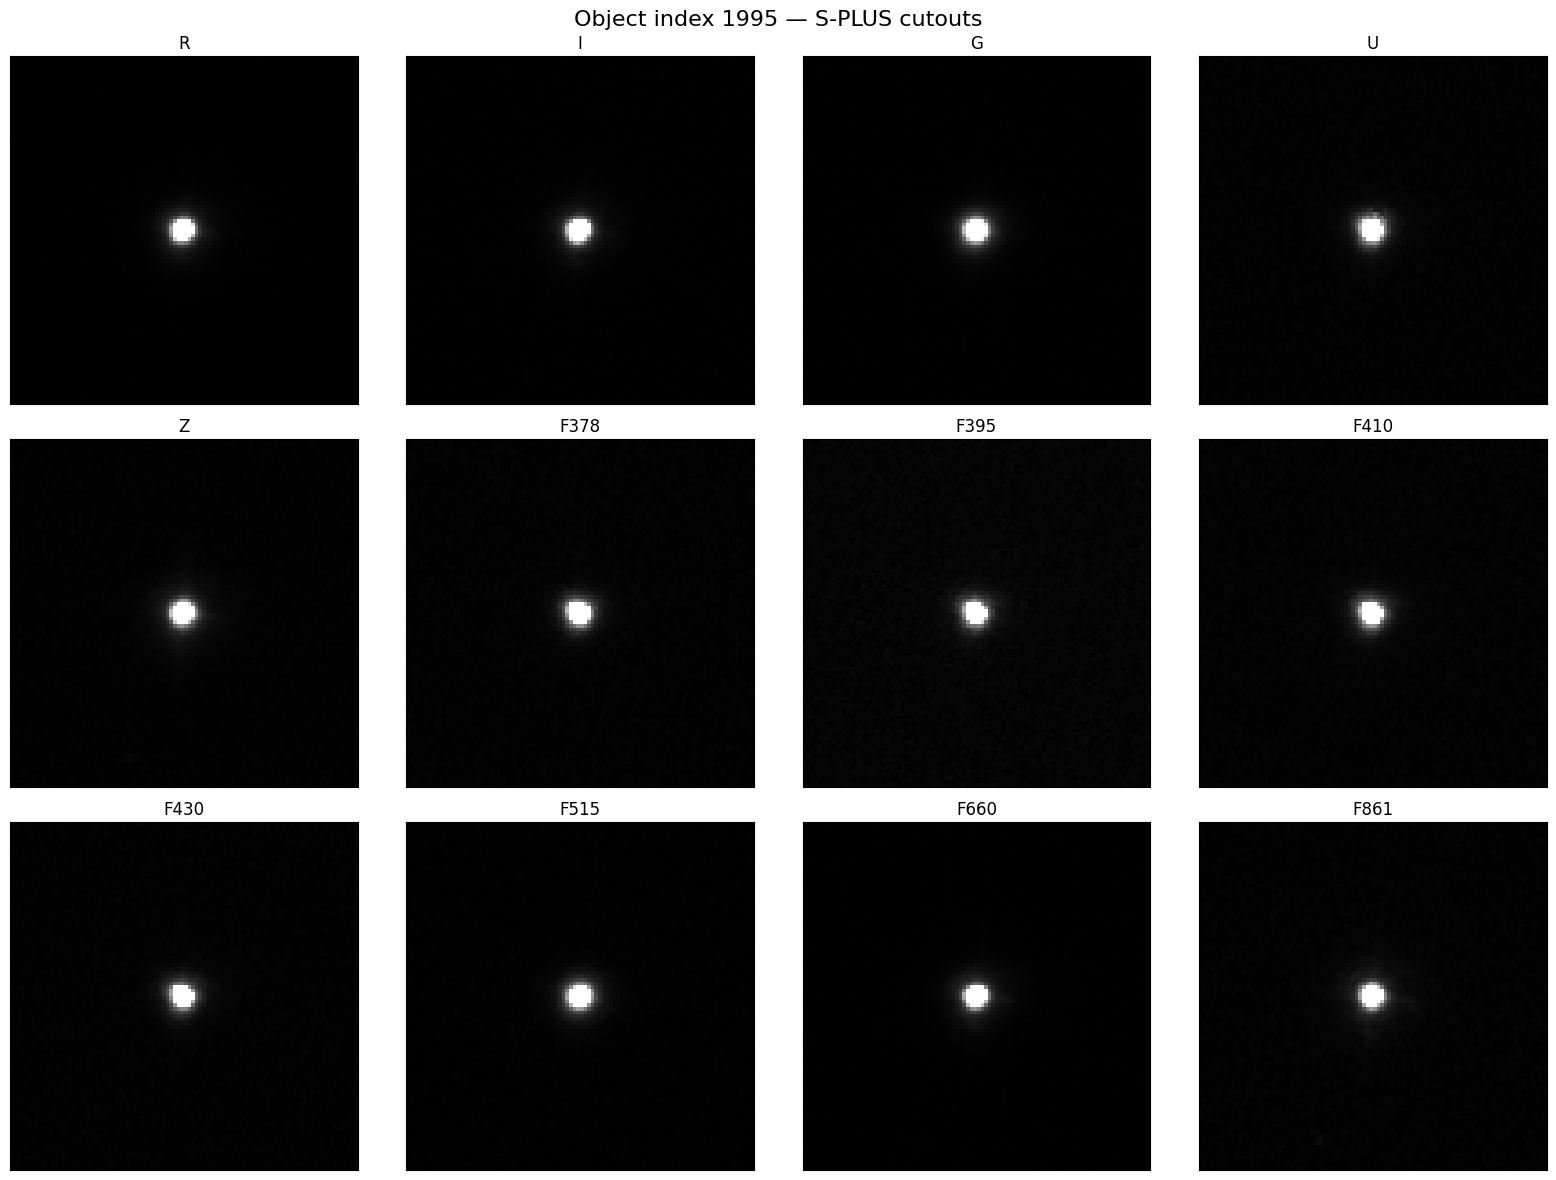

[SPECTRA] No wavelength column found; will use pixel index for x.
No array-like gaiaxp_* columns to plot as spectra.


,id,random_idx,ra,dec,field,a_pixel_det,a_restricted_pixel_r,b_pixel_det,b_restricted_pixel_r,class_star_det,...,specz_z,specz_z_significant_figures,specz_e_z,specz_f_z,specz_original_f_z,specz_class_spec,specz_subclass,specz_subsubclass,specz_original_class_spec,specz_source
0,b'i06S82000100000',78988955,359.326661,-1.412885,b'STRIPE82-0001',0.510947,0.510947,0.488726,0.488726,0.349743,...,NaN,NaN,NaN,NaN,None,None,None,None,None,None
1,b'i06S82000100001',87233933,359.331556,-1.412733,b'STRIPE82-0001',0.506796,0.506796,0.491438,0.491438,0.349869,...,NaN,NaN,NaN,NaN,None,None,None,None,None,None
2,b'i06S82000100002',116739303,359.549595,-1.412636,b'STRIPE82-0001',0.506652,0.506652,0.492518,0.492518,0.350482,...,NaN,NaN,NaN,NaN,None,None,None,None,None,None
3,b'i06S82000100003',90025356,359.305005,-1.412760,b'STRIPE82-0001',0.844294,0.844294,0.353997,0.353997,0.350129,...,NaN,NaN,NaN,NaN,None,None,None,None,None,None
4,b'i06S82000100004',40969914,359.352022,-1.412511,b'STRIPE82-0001',1.186475,1.186475,0.336744,0.336744,0.349256,...,NaN,NaN,NaN,NaN,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53992,b'i06S820001015NS',17622082,0.516515,-0.095967,b'STRIPE82-0001',2.039208,2.039208,1.738197,1.738197,0.000121,...,NaN,NaN,NaN,NaN,None,None,None,None,None,None
53993,b'i06S820001015NT',103408444,0.297338,-0.095844,b'STRIPE82-0001',1.603435,1.603435,0.993441,0.993441,0.000250,...,NaN,NaN,NaN,NaN,None,None,None,None,None,None
53994,b'i06S820001015NU',29188256,359.745180,-0.100063,b'STRIPE82-0001',1.566600,1.566600,1.243641,1.243641,0.000811,...,NaN,NaN,NaN,NaN,None,None,None,None,None,None
53995,b'i06S820001015NV',142961355,359.916280,-0.089911,b'STRIPE82-0001',0.847641,0.847641,0.491313,0.491313,0.346794,...,NaN,NaN,NaN,NaN,None,None,None,None,None,None


In [20]:
# inspect row 42, using the existing df (no re-load)
inspect_object(df=df, idx=1995)

In [33]:
# not nan spec_z
df[(df['gaia_has_xp_sampled'] == True)][['gaia_source_id', 'gaiaxp_source_id']]

,gaia_source_id,gaiaxp_source_id
1995,2449704931658296320,NaN
2179,2449694181356286976,NaN
2212,2449527089948630016,NaN
2508,2449706172904975872,2.449706e+18
2583,2449715484394104832,NaN
...,...,...
51739,2546022669943970816,2.546023e+18
52145,2449956964635373568,NaN
52245,2545975700181622784,NaN
53611,2545976078138744832,NaN


In [34]:
df.iloc[2508]['gaia_source_id'] == df.iloc[2509]['gaiaxp_source_id']

np.False_

In [16]:
df[df['gaiaxp_bp_coefficients'].notna()][['gaia_source_id', 'gaiaxp_solution_id', 'gaiaxp_bp_coefficients', 'gaiaxp_rp_coefficients']]

,gaia_source_id,gaiaxp_solution_id,gaiaxp_bp_coefficients,gaiaxp_rp_coefficients
492,2.449693e+18,4.545469e+18,"[233.3076081027179, -35.79103271443662, -2.120...","[230.55892977907942, -33.28081447292042, -0.35..."
1603,2.449715e+18,4.545469e+18,"[114.88297495247288, -26.443884830679874, 2.79...","[103.84813590646839, -16.08663458746901, -0.71..."
1675,2.449715e+18,4.545469e+18,"[114.88297495247288, -26.443884830679874, 2.79...","[103.84813590646839, -16.08663458746901, -0.71..."
2508,2.449706e+18,4.545469e+18,"[1279.331065951184, -85.41171225638216, -42.86...","[1532.2309828603445, -161.2968174201516, -0.58..."
3295,2.449530e+18,4.545469e+18,"[2667.7375846468585, -548.7470411237621, 38.04...","[2436.604710252278, -392.05390301871296, -24.7..."
...,...,...,...,...
51711,2.546023e+18,4.545469e+18,"[69.81921972871167, 10.982632792533542, 0.5472...","[263.95547930174564, 54.664732499582705, 14.66..."
51739,2.546023e+18,4.545469e+18,"[3146.140981464542, -454.5984482138563, -36.55...","[3170.2928153668768, -462.4791563052513, -25.8..."
52614,2.546023e+18,4.545469e+18,"[69.81921972871167, 10.982632792533542, 0.5472...","[263.95547930174564, 54.664732499582705, 14.66..."
52913,2.546019e+18,4.545469e+18,"[236.78013027685427, 14.99707556989692, -11.08...","[390.4072685712321, -11.137309570342627, 7.025..."


In [9]:
list(df.columns)

['id',
 'random_idx',
 'ra',
 'dec',
 'field',
 'a_pixel_det',
 'a_restricted_pixel_r',
 'b_pixel_det',
 'b_restricted_pixel_r',
 'class_star_det',
 'class_star_g',
 'class_star_i',
 'class_star_j0378',
 'class_star_j0395',
 'class_star_j0410',
 'class_star_j0430',
 'class_star_j0515',
 'class_star_j0660',
 'class_star_j0861',
 'class_star_r',
 'class_star_u',
 'class_star_z',
 'ellipticity_det',
 'elongation_det',
 'err_a_pixel_det',
 'err_b_pixel_det',
 'err_mag_aper_3_g',
 'err_mag_aper_3_i',
 'err_mag_aper_3_j0378',
 'err_mag_aper_3_j0395',
 'err_mag_aper_3_j0410',
 'err_mag_aper_3_j0430',
 'err_mag_aper_3_j0515',
 'err_mag_aper_3_j0660',
 'err_mag_aper_3_j0861',
 'err_mag_aper_3_r',
 'err_mag_aper_3_u',
 'err_mag_aper_3_z',
 'err_mag_aper_6_g',
 'err_mag_aper_6_i',
 'err_mag_aper_6_j0378',
 'err_mag_aper_6_j0395',
 'err_mag_aper_6_j0410',
 'err_mag_aper_6_j0430',
 'err_mag_aper_6_j0515',
 'err_mag_aper_6_j0660',
 'err_mag_aper_6_j0861',
 'err_mag_aper_6_r',
 'err_mag_aper_6_u',
 '